In [1]:
import pandas as pd
import numpy as np
import random
import time
import functools

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import AdaBoostRegressor

from matplotlib import pyplot as plt

In [2]:
data = load_diabetes(as_frame=True)
X, y = data['data'], data['target']

display(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [3]:
class Node():
    
    def __init__(self, 
                 node_type = 'Node', 
                 side=None, 
                 feature = None, 
                 split_value = None, 
                 parent=None, 
                 *, node_depth = None,  
                 ID = None, 
                 value = None, 
                 children=[]):
        self.node_type = node_type # Leaf or Node        
        self.side = side # Left or Right
        self.feature = feature
        self.split_value = split_value
        self.parent = parent
        
        self.node_depth = node_depth 
        self.ID = ID
        self.value = value # только для листьев 
        self.children = []
        
        self.Np = 0 # количество точек в узле
        
        self.leaf_targets_index = None
                    
    def set_value(self, new_value: float) -> None:
        self.value = new_value
        
    def add_child(self, new_value: float) -> None:
        self.children.append(new_value)
        
class MyTreeReg():
    
    def __init__(self, 
                 max_depth = 5,  
                 min_samples_split =2, 
                 max_leafs = 20, 
                 bins = None): 
        self.max_depth = max_depth 
        self.min_samples_split = min_samples_split 
        self.max_leafs = max_leafs 
        self.bins = bins
        
        self.tree = []
        self.leafs_cnt = 0 
        self.potential_leafs_cnt = 1 
        self.leafs_sum = 0 
        
        self.histogram = {}
        
        self.fi = {}
        
        self.N = 0
                
    def __repr__(self):
        return f'MyTreeReg class: max_depth={self.max_depth}, min_samples_split={self.min_samples_split}, max_leafs={self.max_leafs}'
    
    def fit(self, X, y): 
        if self.bins != None:
            for feature in X.columns:
                self.histogram.update({feature: self.get_hist_delimeters(X[feature].values)})
                
        for feature in X.columns:
            self.fi.update({feature: 0})
        
        self.N = len(y.values)
        
        # построение корневого узла
        feature, split_value, ig = self.get_best_split(X,y)
        X_left, y_left, X_right, y_right, y_left_idx, y_right_idx = self.split_dataframe(X, y, feature, split_value)
        if ig == 0.0 or len(y_left) == 0 or len(y_right) == 0:            
            print('All targets belong to class:', np.sum(y.values)/len(y.values) )
        else:
            _node = self.register_Node("Node", None, feature, split_value, None, y, None)
            
            # изменение feature importance
            _node.Np = len(y.values)
            self.update_fi(y, _node, None)
            
            # построение дерева
            self.grow_tree(X_left, y_left, 'Left', _node, y_left_idx)
            self.grow_tree(X_right, y_right, 'Right', _node, y_right_idx)            
        
    def grow_tree(self, X, y, side, parent, y_idx): 
        feature, split_value, ig = self.get_best_split(X,y)
        X_left, y_left, X_right, y_right,y_left_idx, y_right_idx = self.split_dataframe(X, y, feature, split_value)
        
        if ig != 0.0 and len(y_left) != 0 and len(y_right) != 0 and (parent.node_depth < self.max_depth) and (len(y.values) >= self.min_samples_split) and (self.leafs_cnt + self.potential_leafs_cnt < self.max_leafs):
            _node = self.register_Node('Node', side, feature, split_value, parent, y, y_idx)
            
            # изменение feature importance
            _node.Np = len(y.values)
            self.update_fi(y, _node, parent)
            
            # рекурсивный рост дерева
            self.grow_tree(X_left, y_left, 'Left', _node, y_left_idx)
            self.grow_tree(X_right, y_right, 'Right', _node, y_right_idx)
        else:
            _node = self.register_Node('Leaf', side, feature, split_value, parent, y, y_idx)
            
            # изменение feature importance
            _node.Np = len(y.values)
            self.update_fi(y, _node, parent)
            return _node

    def register_Node(self, node_type, side, feature, split_value, parent, y, y_idx):
        #1.setting node depth
        if parent != None:
            node_depth = parent.node_depth +1
        else:
            node_depth = 1
            
        #2.setting node ID
        if node_type == 'Node':
            if side == 'Left':
                 ID = parent.ID + '.1' 
            elif side == 'Right':
                 ID = parent.ID + '.2'
            else:
                ID = '1'
        
        if node_type == 'Leaf':
            ID = parent.ID
            
        #3.Setting node value
        if node_type == 'Leaf':
            value = np.mean(y.values)
        else:
            value = None
        
        new_node = Node(node_type, side, feature, split_value, parent, node_depth=node_depth, ID=ID, value=value)
        new_node.leaf_targets_index = y_idx
        self.tree.append(new_node)
        
        #add as a child to parent node
        if parent != None :                            
            parent.add_child(new_node)
            
        #update counts
        if node_type == "Node":
            self.potential_leafs_cnt = self.potential_leafs_cnt + 1
        elif node_type == "Leaf":
            self.leafs_cnt = self.leafs_cnt + 1
            self.potential_leafs_cnt = self.potential_leafs_cnt - 1
            self.leafs_sum = self.leafs_sum + value
        return new_node
        
            
    def print_tree_full(self):
        for node in self.tree:
                print(node.__dict__)
    
    def print_tree(self):
        for node in self.tree:
            if node.node_type == 'Node':
                
                print(node.__dict__['ID'], node.__dict__['feature'], '>', node.__dict__['split_value'])
            else:
                print(node.__dict__['ID'],node.__dict__['side'], '-', node.__dict__['value'])
                
    def move_up_the_tree(self, X, _node,i):
        if _node.node_type =='Leaf':
            self.predictions[i]=float(_node.value)
        elif _node.node_type =='Node': 
            if X[_node.feature] <= _node.split_value:
                if _node.children[0].side =='Left':
                    self.move_up_the_tree(X, _node.children[0],i)
                else: self.move_up_the_tree(X, _node.children[1],i)
               
            else:
                if _node.children[0].side =='Right':
                    self.move_up_the_tree(X, _node.children[0],i)
                else: self.move_up_the_tree(X, _node.children[1],i)

    def predict(self,X):
        self.predictions = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            self.move_up_the_tree(X.iloc[i,:], self.tree[0],i)
        return(self.predictions)
        
    #Calculate the best split
    def MSE(self, y): # receives 1D numpy array
        return np.mean(np.square(y-np.mean(y)))

    def data_split(self, X, y, threshold): #receives two 1D numpy arrays and a float
        X_left = X[X <= threshold]
        y_left = y[X <= threshold]
        X_right = X[X > threshold]
        y_right = y[X > threshold]
        return X_left, y_left, X_right, y_right
    
    def get_IG(self, X, y, threshold): #receives two numpy arrays and a float
        #split the data by the threshold
        _, y_left, __, y_right = self.data_split(X, y, threshold)
        if len(y_left) == 0 or len(y_right) == 0: #threshold does not split the data
            return 0.0
        else:
            S0 = self.MSE(y)
            S1 = self.MSE(y_left)*len(y_left)/len(y)
            S2 = self.MSE(y_right)*len(y_right)/len(y)
            IG = S0 - S1 -S2
            return IG
        
    def get_native_delimeters(self, X): #receives 1D numpy array
        X_unique = np.unique(np.sort(X))
        native_delimeters = [np.mean([X_unique[i-1], X_unique[i]]) for i in range(1, len(X_unique))]
        return native_delimeters
    
    def get_hist_delimeters(self, X): #receives 1D numpy array
        hist_delimeters = np.histogram(X, self.bins)[1][1:-1]
        return hist_delimeters
    
    def get_best_split(self, X, y): #receives panda dataframe and panda series
        feature_best_split = {}
        for feature in X.columns:
            if len(X[feature].values) == 0 or np.max(X[feature].values) == np.min(X[feature].values):
                feature_best_split.update({feature: [None, 0.0]}) #feature has no values or any delimeters
            else:
                if self.bins == None:                    
                    feature_delimeters = self.get_native_delimeters(X[feature].values)
                else: 
                    X_unique = np.unique(np.sort(X))
                    if len(X_unique) <= self.bins:
                        feature_delimeters = self.get_native_delimeters(X[feature].values)
                    else:
                         feature_delimeters = self.histogram[feature]
                    
                feature_igs = [self.get_IG(X[feature].values, y.values, feature_delimeters[i]) for i in range(len(feature_delimeters))]
                feature_best_split.update({feature: [feature_delimeters[np.argmax(feature_igs)],np.max(feature_igs)]})
        
        split_value, ig   = max(feature_best_split.values(), key=lambda x: x[1])
        feature = next(k for k, v in feature_best_split.items() if v == [split_value, ig])
        return feature, split_value, ig
        
    def split_dataframe(self, X, y, feature, threshold): #X,y - np.arrays, threshold - float
        X_left = X[X[feature] <= threshold]
        y_left = y[X[feature] <= threshold]
        X_right = X[X[feature] > threshold]
        y_right = y[X[feature] > threshold]
        return X_left, y_left.drop(columns='index'), X_right, y_right.drop(columns='index'), y_left.index.values, y_right.index.values
    
    def update_fi(self, y, _node, parent):
        if _node.node_type == 'Node':
            FI = self.MSE(y.values)*_node.Np/self.N         
            self.fi.update({_node.feature: self.fi[_node.feature] + FI })
        
        if parent != None:
            FI = self.MSE(y.values)*_node.Np/self.N
            self.fi.update({parent.feature: self.fi[parent.feature] - FI })
            

In [4]:
class MyBoostReg():   
    """
    Градиентный бустинг над решающими деревьями, регрессия
    ----------
    Параметры:
    n_estimators : int
        Количество базовых моделей, by default 10.
    learning_rate : float | int | function
        Скорость обучения базовых моделей (коэффициенты суммирования деревье). 
        Принимает значения int, float и лямбда-функции, by default 0.1.
    max_depth : int
        Максимальная глубина дерева, by default 5.
    min_samples_split : int
        Кол-во объектов в листе, чтобы его можно было разбить и превратить в узел by default 2.  
    max_leafs : int
        Максимальное количество листьев у дерева by default 20.
    bins: int, optional
        Количество бинов, разбивающее фичи при обучении, by default None.
    loss : str
        Лосс, на котором обучаются деревья. Реализуемые лоссы: MSE и MAE, by default MSE.
    metric : str, optional
        Метрика для оценивания качества модели. Реализуемые метрики: MSE, RMSE, MAE, MAPE, R2, by default None.
    max_features : float
        Доля фичей, отбираемая случайный образом из датасета для каждого дерева, by default 0.5.
    max_samples : float    
        Доля сэмплов, отбираемая случайный образом из датасета для каждого дерева, by default 0.5.
    reg : float
        Параметр регулиризации, штраф за большое количество листьев, by default 0.1.
    random_state : int
        Фиксирование сида для воспроизводимости модели, by default 42.
    ----------
    Методы:
    fit : построение регрессора дерева принятия решений из обучающего набора.
    predict: получение прогнозируемых значений регрессии для датасета Х.
    feature_importances: получение массива важности фичей
    best_score: возвращает последний скор
    """
    
    @staticmethod
    def timer(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start = time.perf_counter()
            val = func(*args, **kwargs)
            end = time.perf_counter()
            work_time = end - start
            print(f'Время выполнения {func.__name__}: {round(work_time, 4)} сек.')
            return val
        return wrapper
      
    def __init__(self, 
                 n_estimators=10, 
                 learning_rate = 0.1, 
                 max_depth = 5, 
                 min_samples_split = 2, 
                 max_leafs = 20, 
                 bins = None, 
                 loss = 'MSE', 
                 metric = None,
                 max_features = 0.5, 
                 max_samples = 0.5, 
                 reg = 0.1,
                 random_state = 42) -> None:
        
        # настройка бустинга
        self.n_estimators= n_estimators
        self.learning_rate = learning_rate
        self.loss = loss
        self.metric = metric if metric is not None else loss
        self.max_features = max_features
        self.max_samples = max_samples
        self.random_state = random_state
        self.reg =  reg
        
        # настройка деревьев
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leafs = max_leafs
        self.bins = bins
        
        self.trees_leafs_cnt=0 
        self.pred_0 = None # нулевое предсказание
        self.trees = [] # список для сохранения деревьев
        self.fi = None # feature importance     
              
        self.best_score = None # последний скор
        
        # формулы для вычисления метрик
        self.metrics = {
            'MAE':  lambda y, y_pred: np.mean(np.abs(y - y_pred)),
            'MSE':  lambda y, y_pred: np.mean((y - y_pred) ** 2),
            'RMSE': lambda y, y_pred: np.sqrt(np.mean((y - y_pred) ** 2)),
            'MAPE': lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100,
            'R2':   lambda y, y_pred: 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
        }
        
        # формулы для вычисления градиентов
        self.gradients = {
            'MAE': lambda predictions, y_true: np.sign(predictions - y_true),
            'MSE': lambda predictions, y_true: 2 * (predictions - y_true)
        }                                
    
    @timer
    def fit(self, 
            X: pd.DataFrame, 
            y: pd.Series, 
            *,
            X_eval: pd.DataFrame = None,
            y_eval: pd.Series = None, 
            early_stopping: int = None, 
            verbose: int = None) -> None:
        """Обучение дерева принятия решений

        Parameters
        ----------
        X : pd.DataFrame
            Все фичи
        y : pd.Series
            Целевая переменная
        X_eval : pd.DataFrame, optional
            Валидационный датасет для ранней остановки
        y_eval : pd.Series, optional
            Валидационная переменная для ранней остановки
        early_stopping: int, optional
            Параметр для ранней остановки. Если метрика не улучшается early_stopping раз, то обучение прекращается
        verbose : int, optional
            Вывод лога каждые verbose раз
        """
        random.seed(self.random_state)  
        X.reset_index(drop=True, inplace=True)
        y.reset_index(drop=True, inplace=True)
        
        # вычисление нулевого предсказания
        if self.loss == 'MSE':
            self.pred_0 = y.mean()
        elif self.loss == 'MAE':
            self.pred_0 = y.median()
        
        # инициация доп. параметров
        self.fi = {i: .0 for i in X.columns}
        predictions = np.ones(y.shape[0]) * self.pred_0        
        eval_metrics = []
        best_scores = []
        stop = None
        
        # цикл по количеству заданных деревье
        for i in range(self.n_estimators):
            gradient = self.gradients[self.loss](predictions, y)                                      
            
            # сэмплирование 
            cols_idx = random.sample(list(X.columns), round(self.max_features * X.shape[1]))
            rows_idx = random.sample(list(X.index), round(self.max_samples * X.shape[0]))
            
            # обучение
            tree = MyTreeReg(self.max_depth, self.min_samples_split, self.max_leafs, self.bins) 
            tree.fit(X.loc[rows_idx, cols_idx], - gradient[rows_idx])
            for col in tree.fi:
                self.fi[col] += tree.fi[col] / X.shape[1]
            
            # обновление значений листьев
            for node in tree.tree:
                if node.node_type == 'Leaf':
                    
                    y_ = y.loc[node.leaf_targets_index].values
                    pred = predictions[node.leaf_targets_index] 
                    
                    if self.loss == 'MSE':
                        node.set_value(np.mean(y_ - pred) + self.reg * self.trees_leafs_cnt)
                    elif self.loss == 'MAE':
                        node.set_value(np.median(y_ - pred) + self.reg * self.trees_leafs_cnt) 
            
                
            
            # сохранение дерева внутри инстанса модели
            self.trees.append(tree)
            best_scores.append(self.metrics[self.metric](y, predictions))
            self.trees_leafs_cnt += tree.leafs_cnt
            
            # с помощью обновленного дерева делаем предсказание на тренировочном датасете
            # добавляем предсказание к текущему с поправкой на Learning Rate
            predictions += self.__get_learning_rate(i) * tree.predict(X)
            
            # вывод лога
            if verbose and i % verbose == 0:
                current_loss = self.__get_loss(y, predictions)
                print(f"{i}. Loss[{self.loss}]: {current_loss:.2f}")
                
            # проверка на раннюю остановку
            if early_stopping:
                prediction_eval = self.predict(X_eval)
                eval_metrics.append(self.metrics[self.metric](y_eval, prediction_eval))
                try:
                    if eval_metrics[-1] >= eval_metrics[-1 - early_stopping]:
                        stop = i
                        self.best_score = self.metrics[self.metric](y, predictions)  
                        print(f'Ранняя остановка на {i} шаге')
                        break
                except:
                    continue
        # если сработала остановка, то переписываем скор и изменяем количество деревьев в моделе
        if stop:
            self.trees = self.trees[:stop - early_stopping + 1]
            self.best_score = best_scores[-early_stopping]   
        else:
            self.best_score = best_scores[-1]       
            
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Выдача предсказаний моделью

        Parameters
        ----------
        X : pd.DataFrame
            Матрица фичей
        """
        predictions = np.ones(X.shape[0]) * self.pred_0        
        for i, tree in enumerate(self.trees):
            predictions = predictions + self.__get_learning_rate(i) * tree.predict(X)
        return predictions 
    
    def feature_importances(self) -> np.ndarray:
        """Получение матрицы относительной важности фичей"""
        arr = np.array([i for i in self.fi.values()])
        t_min = 0
        t_max = arr.max() / arr.sum()
        norm_arr = []
        diff_arr = max(arr) - min(arr)    
        for i in arr:
            temp = (((i - min(arr)) * t_max) / diff_arr) + t_min
            norm_arr.append(temp)
        return np.array(norm_arr)
    
    def __get_loss(self, y: np.ndarray | pd.Series, pred: np.ndarray | pd.Series) -> float:
        if self.loss == 'MSE':
            return np.mean(np.square(y - pred))
        elif self.loss == 'MAE':
            return np.mean(np.abs(y - pred))
        
    def __get_learning_rate(self, i: int) -> float:
        if isinstance(self.learning_rate, (int, float)):
            return self.learning_rate 
        else:
            return self.learning_rate(i + 1)
    
    def __str__(self) -> str:
        return f'MyBoostReg class: n_estimators={self.n_estimators}, learning_rate={self.learning_rate}, max_depth={self.max_depth}, min_samples_split={self.min_samples_split}, max_leafs={self.max_leafs}, bins={self.bins}'
    
    def __repr__(self) -> str:
        return f'MyBoostReg class: {self.__dict__}'

In [28]:
my_boost = MyBoostReg(n_estimators=50, 
                   learning_rate=lambda x: 0.7 * 0.8 ** x, 
                   metric="RMSE", 
                   loss='MSE', 
                   max_depth=3, 
                   bins=None,
                   reg = 0.1, 
                   max_features = 0.9, 
                   max_samples = 0.9)
my_boost.fit(X_train, y_train, X_eval=X_test, y_eval=y_test, early_stopping=2, verbose=5)
y_pred = my_boost.predict(X_test)
mean_squared_error(y_pred, y_test)

0. Loss[MSE]: 3522.68
5. Loss[MSE]: 2098.13
10. Loss[MSE]: 1942.07
Ранняя остановка на 10 шаге
Время выполнения fit: 2.2329 сек.


2894.622148168508

Массив feature importance: 
 [0.02784646 0.00692803 0.30544821 0.03366607 0.05160362 0.
 0.17549982 0.0264772  0.17778639 0.113011  ]


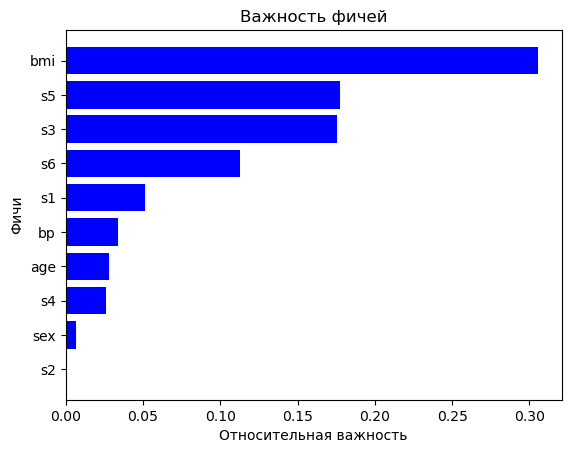

In [6]:
#feature importance
print('Массив feature importance:', '\n', my_boost.feature_importances())

features = X.columns
importances = my_boost.feature_importances()
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Важность фичей')
plt.ylabel('Фичи')
plt.xlabel('Относительная важность')
plt.show()

In [7]:
# модель не настроена, настройки моделей см. в решении задачи
ada_boost = AdaBoostRegressor(random_state=0, n_estimators=50)
ada_boost.fit(X_train, y_train)
y_pred_ada = ada_boost.predict(X_test)
mean_squared_error(y_pred_ada, y_test)

2941.432363267126

Массив feature importance: 
 [0.04287376 0.00974449 0.32007362 0.1079832  0.04362337 0.03886515
 0.08375951 0.02065499 0.21154274 0.12087917]


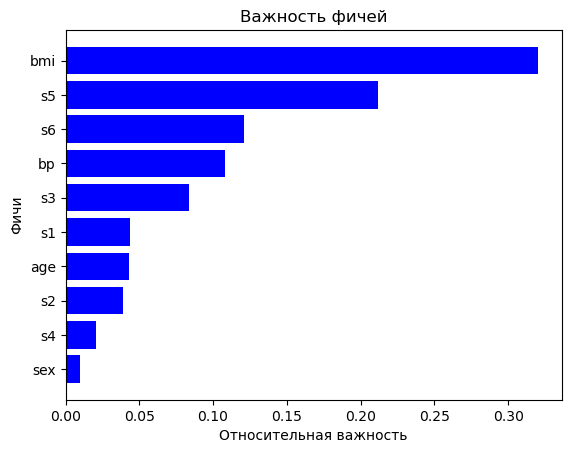

In [8]:
#feature importance
print('Массив feature importance:', '\n', ada_boost.feature_importances_)

features = X.columns
importances = ada_boost.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Важность фичей')
plt.ylabel('Фичи')
plt.xlabel('Относительная важность')
plt.show()

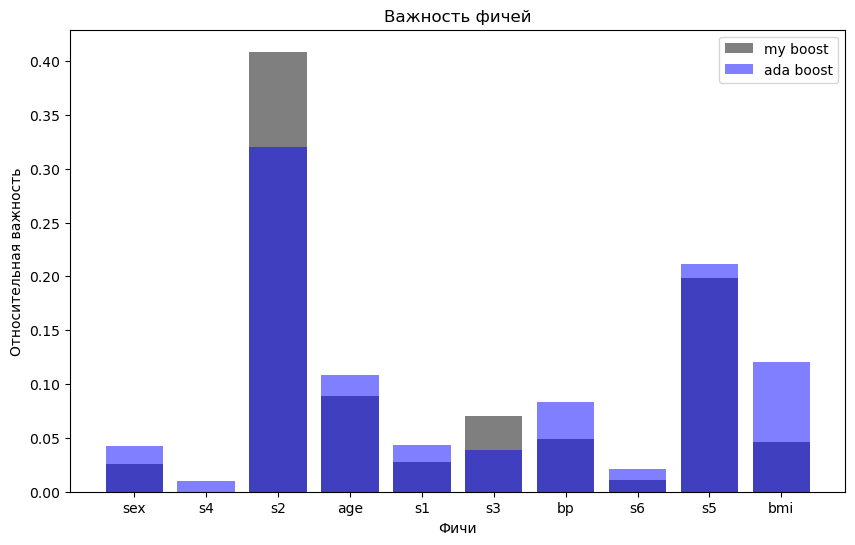

In [29]:
plt.figure(figsize=(10, 6))

my = my_boost.feature_importances()
ada = ada_boost.feature_importances_
features = X.columns

importances = ada_boost.feature_importances_
indices = np.argsort(importances)

plt.bar([features[i] for i in indices], my,
         color='black', alpha=0.5)

plt.bar([features[i] for i in indices], ada,
         color='blue', alpha=0.5)

plt.legend(['my boost', 'ada boost'])
plt.title('Важность фичей')
plt.xlabel('Фичи')
plt.ylabel('Относительная важность')

plt.show()